In [1]:
from data_preprocessing.dataloader import loading_data
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--padding', type=str, 
                    default='mean', help='choose one of them : no, max, mean')
parser.add_argument('--timespan', type=int, 
                    default=10000, help='choose of the number of timespan between data points(1000 = 1sec, 60000 = 1min)')
parser.add_argument('--min_seq', type=int, 
                    default=10, help='choose of the minimum number of data points in a example')
parser.add_argument('--min_samples', type=int, default=20, 
                    help='choose of the minimum number of samples in each label')
parser.add_argument('--selected_dataset', default='lapras', type=str,
                    help='Dataset of choice: lapras, casas, opportunity, aras_a, aras_b')
parser.add_argument('--aug_method', type=str, default='AddNoise', help='choose the data augmentation method')
parser.add_argument('--aug_wise', type=str, default='Temporal', help='choose the data augmentation wise')

parser.add_argument('--test_ratio', type=float, default=0.2, help='choose the number of test ratio')

args = parser.parse_args(args=[])
data_type = args.selected_dataset

# DOO-RE
num_classes_DR, datalist_DR, labellist_DR = loading_data('lapras', args)
print(datalist_DR.shape)

# CASAS
num_classes_CS, datalist_CS, labellist_CS = loading_data('casas', args)
print(datalist_CS.shape)

# # Opportunity
args.timespan = 1000
num_classes_OP, datalist_OP, labellist_OP = loading_data('opportunity', args)
print(datalist_OP.shape)

# # ARAS_A
num_classes_AA, datalist_AA, labellist_AA = loading_data('aras_a', args)
print(datalist_AA.shape)


ModuleNotFoundError: No module named 'torch'

/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_

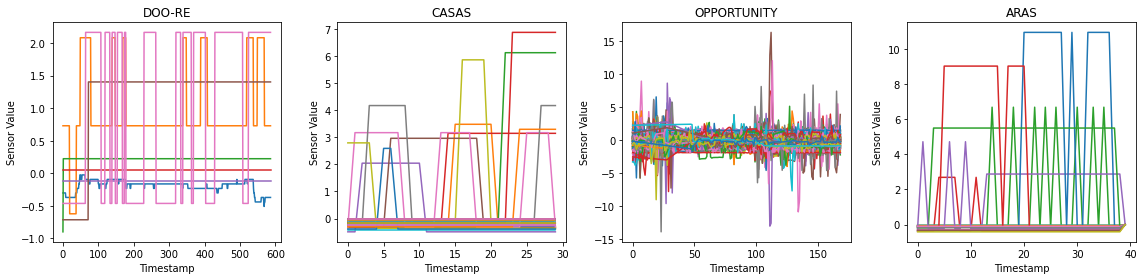

In [ ]:
#Visualization of each dataset
from data_preprocessing.augmentations import select_transformation
import torch
import numpy as np
import matplotlib.pyplot as plt


# 입력 데이터 생성
input_data_1 = torch.tensor(datalist_DR[314]).cuda()  # Activity 1
input_data_2 = torch.tensor(datalist_CS[1]).cuda()  # Activity 1
input_data_3 = torch.tensor(datalist_OP[20]).cuda()  # Activity 1
input_data_4 = torch.tensor(datalist_AA[99]).cuda()  # Activity 1

# 시간 도메인 데이터 시각화
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(input_data_1[11:].cpu().numpy())
plt.title("DOO-RE")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")


plt.subplot(1, 4, 2)
plt.plot(input_data_2[:30].cpu().numpy())
plt.title("CASAS")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")


plt.subplot(1, 4, 3)
plt.plot(input_data_3.cpu().numpy())
plt.title("OPPORTUNITY")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")

plt.subplot(1, 4, 4)
plt.plot(input_data_4[:40].cpu().numpy())
plt.title("ARAS")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")

#plt.legend(labels = ['Seat Occupy', 'Sound', 'Brightness', 'Projector', 'Presentation'],bbox_to_anchor=(1.3, 0.6))
plt.tight_layout()
plt.show()

torch.Size([516, 598, 7])
[1, 2, 3, 4]
torch.Size([598]) torch.Size([598])


/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


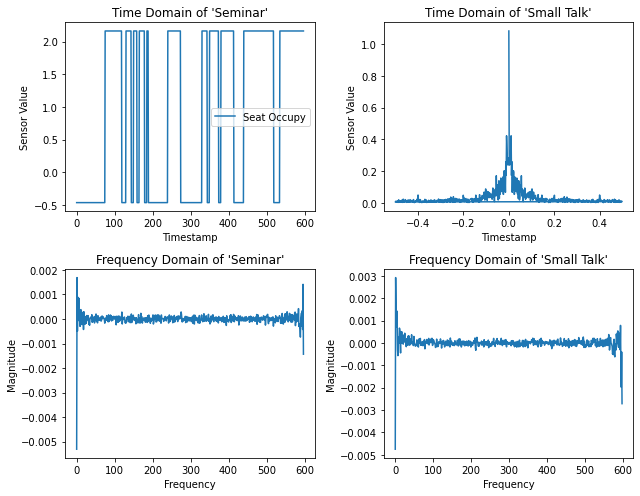

In [ ]:
# Visualization for DOO-RE
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

# [119, 52, 40, 129]
print(datalist_DR.shape)
print(num_classes_DR)


# 입력 데이터 생성
input_data = torch.tensor(datalist_DR[:, : , 6])  # Activity 1
freq_data = torch.fft.fftn(datalist_DR, norm="forward").cpu().numpy()


data = input_data - input_data.mean()
x = torch.fft.fftfreq(598, 1)
y = (torch.fft.fft(data[314])/len(data)).abs()
#99

print(x.shape, y.shape)

# 시간 도메인 데이터 시각화
plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1)
plt.plot(input_data[314].cpu().numpy())
plt.title("Time Domain of 'Seminar'")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 

# 시간 도메인 데이터 시각화
plt.subplot(2, 2, 2)
plt.plot(x.cpu().numpy(), y.cpu().numpy())
plt.title("Time Domain of 'Small Talk'")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")

plt.subplot(2, 2, 3)
plt.plot(freq_data[314,:,5])
plt.title("Frequency Domain of 'Seminar'")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data[16,:,5])
plt.title("Frequency Domain of 'Small Talk'")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


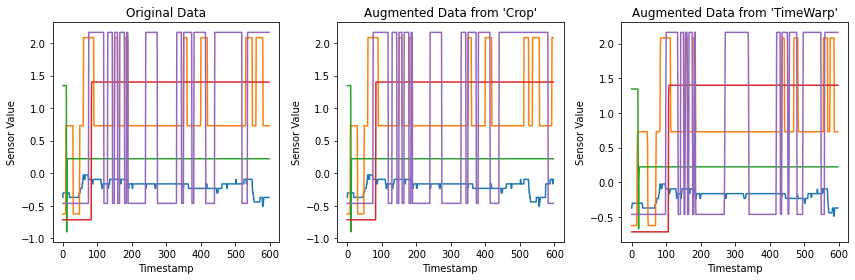

In [ ]:
from data_preprocessing.augmentations import select_transformation
import torch
import numpy as np
import matplotlib.pyplot as plt



X_train = datalist_DR.permute(0, 2, 1)
#X_train = torch.from_numpy(X_train)


pos_aug = select_transformation('Crop', 598)
aug = torch.from_numpy(np.array(pos_aug.augment(
            X_train.permute(0, 2, 1).cpu().numpy())))

# 입력 데이터 생성
input_data_1 = torch.tensor(datalist_DR[314,:,[0,1,2,5,6]]).cuda()  # Activity 1
aug_1 = torch.tensor(aug[314,:,[0,1,2,5,6]]).cuda()

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(input_data_1.cpu().numpy())
plt.title("Original Data")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")


plt.subplot(1, 3, 2)
plt.plot(aug_1.cpu().numpy())
plt.title("Augmented Data from 'Crop'")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")

pos_aug = select_transformation('TimeWarp', 598)
aug = torch.from_numpy(np.array(pos_aug.augment(
            X_train.permute(0, 2, 1).cpu().numpy())))
aug_2 = torch.tensor(aug[314,:,[0,1,2,5,6]]).cuda()

plt.subplot(1, 3, 3)
plt.plot(aug_2.cpu().numpy())
plt.title("Augmented Data from 'TimeWarp'")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")

#plt.legend(labels = ['Seat Occupy', 'Sound', 'Brightness', 'Projector', 'Presentation'],bbox_to_anchor=(1.3, 0.6))
plt.tight_layout()
plt.show()


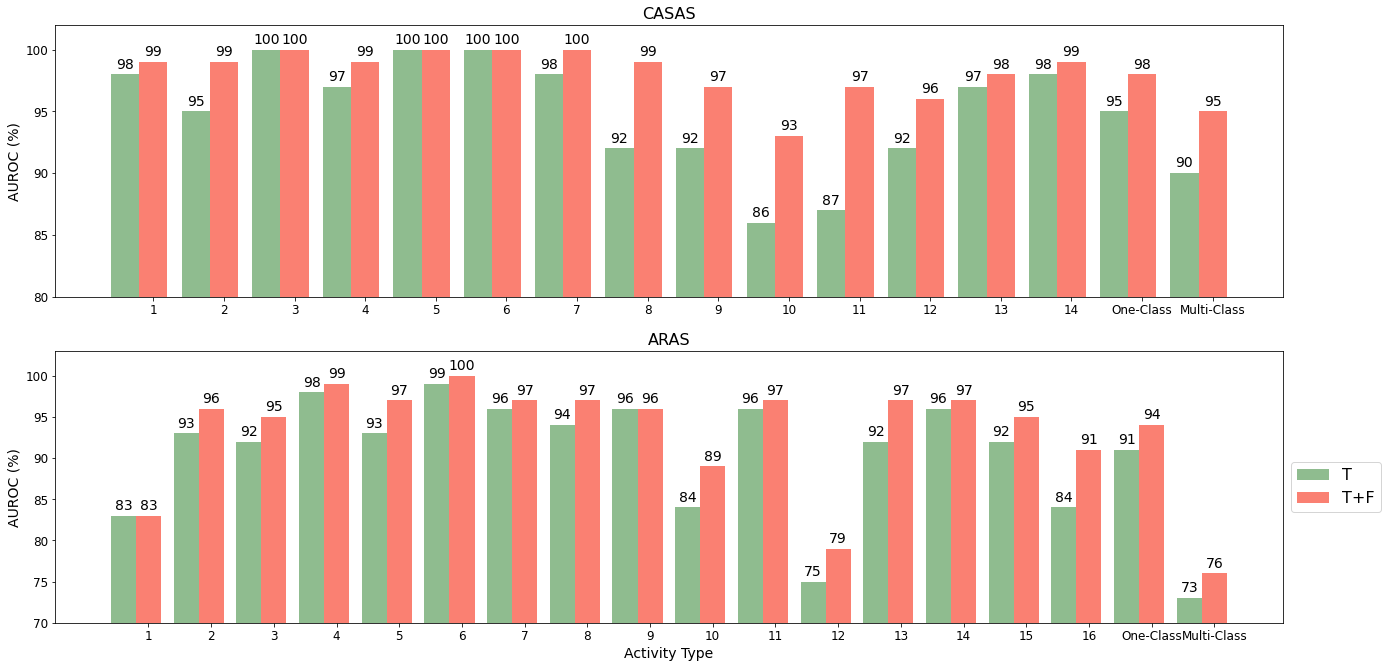

In [ ]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(22,11))
color_list = ['darkseagreen', 'salmon']

ratio  = \
np.array([[98, 99], #1
          [95, 99], #2
          [100, 100], #3
          [97, 99], #4
          [100, 100], #5
          [100, 100], #6
          [98, 100], #7
          [92, 99], #8
          [92, 97], #9
          [86, 93], #10
          [87, 97], #11
          [92, 96], #12
          [97, 98], #13
          [98, 99], #14
          [95, 98], # Mean
          [90, 95]]) #Multi

type_d = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,'One-Class','Multi-Class']
values = {
    'T': ratio[:,0],
    'T+F':  ratio[:,1]
}

x = np.arange(len(type_d))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

plt.subplot(2, 1, 1)


for attribute, measurement in values.items():
    offset = width * multiplier
    # Apply the colormap directly to the bars
    rects = plt.bar(x + offset, measurement, width, label=attribute, color=color_list[multiplier])
    plt.bar_label(rects, padding=3,fontsize=14)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("AUROC (%)",fontsize=14)
plt.title('CASAS', fontsize=16)
plt.xticks(x + width, type_d, fontsize=12)
plt.ylim(80, 102)
plt.yticks([80,85,90,95,100],fontsize=12)

ratio  = \
np.array([[83, 83], #1
          [93, 96], #2
          [92, 95], #3
          [98, 99], #4
          [93, 97], #5
          [99, 100], #6
          [96, 97], #7
          [94, 97], #8
          [96, 96], #9
          [84, 89], #10
          [96, 97], #11
          [75, 79], #12
          [92, 97], #13
          [96, 97], #14
          [92, 95], #14
          [84, 91], #16
          [91, 94], # Mean
          [73, 76]]) #Multi

type_d = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,'One-Class','Multi-Class']
values = {
    'T': ratio[:,0],
    'T+F':  ratio[:,1]
}

x = np.arange(len(type_d))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0


plt.subplot(2, 1, 2)

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = plt.bar(x + offset, measurement, width, label=attribute, color=color_list[multiplier])
    plt.bar_label(rects, padding=3,fontsize=14)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("AUROC (%)",fontsize=14)
plt.title('ARAS', fontsize=16)
plt.xticks(x + width, type_d, fontsize=12)
#plt.legend(loc='upper left')
plt.ylim(70, 103)
plt.yticks(fontsize=12)
plt.xlabel("Activity Type",fontsize=14)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
plt.show()

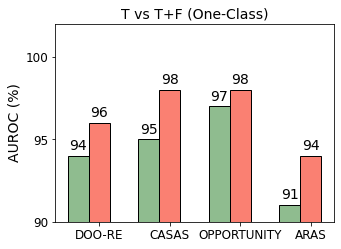

In [6]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,8))
color_list = ['darkseagreen', 'salmon']

ratio  = \
np.array([[94, 96], # DOORE
          [95, 98], # CASAS
          [97, 98], # OPP
          [91, 94]]) #ARAS

type_d = ['DOO-RE', 'CASAS', 'OPPORTUNITY', 'ARAS']
values = {
    'T': ratio[:,0],
    'T+F':  ratio[:,1]
}

x = np.arange(len(type_d))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

plt.subplot(2, 1, 1)


for attribute, measurement in values.items():
    offset = width * multiplier
    # Apply the colormap directly to the bars
    rects = plt.bar(x + offset, measurement, width, label=attribute, color=color_list[multiplier], edgecolor='black')
    plt.bar_label(rects, padding=3,fontsize=14)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("AUROC (%)",fontsize=14)
plt.title('T vs T+F (One-Class)', fontsize=14)
plt.xticks(x + width, type_d, fontsize=12)
plt.ylim(90, 102)
plt.yticks([90,95,100],fontsize=12)

# ratio  = \
# np.array([[96, 96], # DOORE
#           [90, 95], # CASAS
#           [99, 99], # OPP
#           [73, 76]]) #ARAS

# type_d = ['DOO-RE', 'CASAS', 'OPPORTUNITY', 'ARAS']
# values = {
#     'T': ratio[:,0],
#     'T+F':  ratio[:,1]
# }

# x = np.arange(len(type_d))  # the label locations
# width = 0.3  # the width of the bars
# multiplier = 0

# plt.subplot(2, 1, 2)


# for attribute, measurement in values.items():
#     offset = width * multiplier
#     # Apply the colormap directly to the bars
#     rects = plt.bar(x + offset, measurement, width, label=attribute, color=color_list[multiplier])
#     plt.bar_label(rects, padding=3,fontsize=14)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# plt.ylabel("AUROC (%)",fontsize=14)
# plt.title('T vs T+F (Multi-Class)', fontsize=14)
# plt.xticks(x + width, type_d, fontsize=12)
# plt.ylim(90, 102)
# plt.yticks([70, 80, 90,100],fontsize=12)



#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
plt.show()

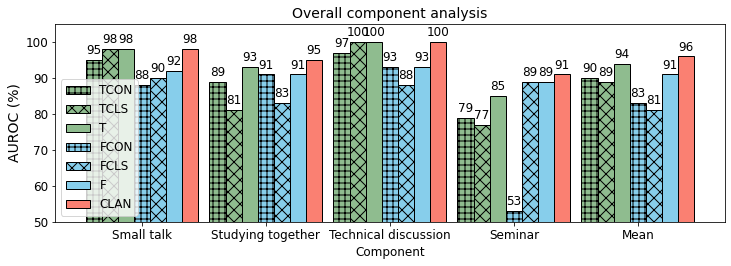

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)

color_list = ['darkseagreen','darkseagreen','darkseagreen', 'skyblue','skyblue', 'skyblue', 'salmon']
type_d = ['Small talk', 'Studying together', 'Technical discussion', 'Seminar', 'Mean']
ratio  = \
np.array([[95, 98, 88, 90, 98 ,92, 98], #0
          [89, 81 , 91 ,83, 93 ,91, 95], #1
          [97, 100, 93, 88, 100, 93, 100], #2
          [79, 77, 53, 89, 85 ,89, 91], #3
          [90, 89, 83, 81, 94, 91, 96]]) #Multi
        #  [91, 91, 86, 80, 96, 88, 96]
values = {
    'TCON': ratio[:,0],
    'TCLS':  ratio[:,1],
    'T':  ratio[:,4],
    'FCON':  ratio[:, 2],
    'FCLS':  ratio[:,3],    
    'F':  ratio[:,5],
    'CLAN':  ratio[:,6],

}

x = np.arange(len(type_d))  # the label locations
width = 0.13  # the width of the bars
multiplier = 0
hatch_patterns = ['++', 'xx', '', '++', 'xx', '', '']

for attribute, measurement in values.items():
    offset = width * multiplier
    # Apply the colormap directly to the bars
    rects = plt.bar(x + offset, measurement, width, label=attribute, color=color_list[multiplier], hatch=hatch_patterns[multiplier], edgecolor='black')
    plt.bar_label(rects, padding=3, fontsize=12)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("AUROC (%)",fontsize=14)
plt.title('Overall component analysis', fontsize=14)
plt.xticks(x + width*3, type_d, fontsize=12)
plt.ylim(50, 105)
plt.yticks(fontsize=12)
plt.xlabel(r"Component",fontsize=12)

plt.legend(loc='lower left', fontsize=12)
plt.show()

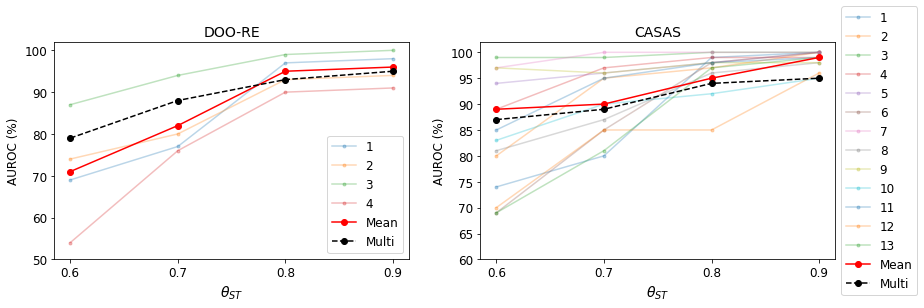

In [ ]:
# performance according to # 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
ratio  = \
np.array([[69, 77, 97, 98], #0
          [74, 80, 93, 94], #1
          [87, 94, 99, 100], #2
          [54, 76, 90, 91], #3
          [71, 82, 95, 96],
          [79, 88, 93, 95]]) #Multi

x = [0.6, 0.7, 0.8, 0.9]


plt.title("DOO-RE",fontsize=14)
for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3, label=str(i+1))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean')
plt.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Multi')

plt.ylabel("AUROC (%)",fontsize=12)
plt.xticks(x,fontsize=12)
#plt.xlabel(r"${\theta_{ST}}$")
plt.ylim([50, 102])
plt.yticks(fontsize=12)
plt.xlabel(r"${\theta_{ST}}$",fontsize=14)
plt.legend(fontsize=12)
#plt.subplots_adjust(left=0.1, right=0.75)  # Adjust left and right margins for the legend


plt.subplot(1, 2, 2)
plt.title("CASAS",fontsize=14)

CA_ratio  = \
np.array([[74, 80, 99, 100], #1
          [80, 95, 97, 100], #2
          [99, 99, 100, 100], #3
          [89, 97, 99, 99], #4
          [94, 96, 98, 100], #5
          [69, 85, 98, 100], #6
          [97, 100, 100, 100], #7
          [81, 87, 96, 98], #8
          [97, 96, 98, 98], #9
          [83, 90, 92, 95], #10
          [85, 95, 98, 99], #11
          [70, 85, 85, 96], #12
          [69, 81, 97, 99], #13
          [89, 90, 95, 99], #14
          [84, 91, 96.6, 98.7], # Mean
          [87, 89, 94, 95] #Multi
])

for i in range(13):
    plt.plot(x, CA_ratio[i], marker='.', alpha=0.3,\
         label=str(i+1))
    
plt.plot(x, CA_ratio[13], marker='o', linestyle='-', color ='red',\
         label='Mean')
plt.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
         label= 'Multi')
plt.ylabel("AUROC (%)", fontsize=12)
plt.xlabel(r"${\theta_{ST}}$",fontsize=14)
plt.ylim([60, 102])
plt.xticks(x,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
# red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
# black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')

# plt.legend(handles=[red_line, black_line], loc ='lower right',fontsize=14)


plt.show()

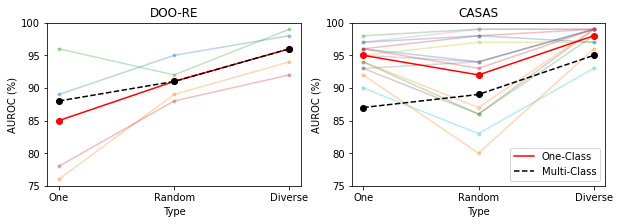

In [ ]:
# performance according to # 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#ratio  = \
# np.array([[97, 89, 98], #0
#           [88, 76, 94], #1
#           [97, 96, 99], #2
#           [80, 78, 92], #3
#           [91, 85, 96],
#           [91, 88, 96]]) #Multi

ratio  = \
np.array([[89, 95, 98], #0
          [76, 89, 94], #1
          [96, 92, 99], #2
          [78, 88, 92], #3
          [85, 91, 96],
          [88, 91, 96]]) #Multi

x = ['One', 'Random', 'Diverse']
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)

for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3,\
         label=str(i))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean.One-Class')
plt.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Multi-class')


plt.title("DOO-RE")
plt.xlabel("Type")
plt.ylabel("AUROC (%)")
plt.ylim([75, 100])
#plt.legend()

plt.subplot(1, 2, 2)
plt.title("CASAS")

CA_ratio  = \
np.array([[96, 94, 99], #1
          [94, 87, 99], #2
          [98, 99, 99], #3
          [96, 98, 99], #4
          [95, 94, 99], #5
          [93, 86, 99], #6
          [97, 99, 99], #7
          [93, 94, 99], #8
          [95, 97, 97], #9
          [90, 83, 93], #10
          [97, 98, 97], #11
          [92, 80, 96], #12
          [94, 86, 98], #13
          [96, 93, 99], #14
          [95, 92, 98], # Mean
          [87, 89, 95]]) #Multi
ratio  = \
np.array([[96, 98, 99], #1
          [94, 83, 99], #2
          [98, 100, 100], #3
          [96, 98, 99], #4
          [95, 82, 100], #5
          [93, 64, 100], #6
          [97, 98, 100], #7
          [93, 61, 99], #8
          [95, 90, 97], #9
          [90, 69, 93], #10
          [97, 96, 97], #11
          [92, 57, 96], #12
          [94, 64, 98], #13
          [96, 70, 99], #14
          [95, 81, 98], # Mean
          [87, 88, 95]]) #Multi
for i in range(14):
    plt.plot(x, CA_ratio[i], marker='.', alpha=0.3,\
         label=str(i))
    
plt.plot(x, CA_ratio[14], marker='o', linestyle='-', color ='red',\
         label='Mean.One-Class')
plt.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
         label= 'Multi-class')
plt.ylabel("AUROC (%)")
plt.xlabel("Type")
plt.ylim([75, 100])

red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')

plt.legend(handles=[red_line, black_line], loc ='lower right')

plt.show()


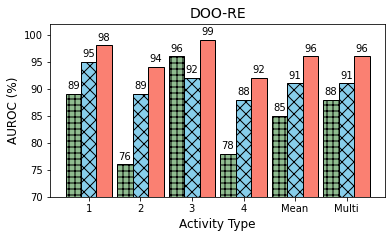

In [ ]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,7))
color_list = ['darkseagreen', 'skyblue', 'salmon']

ratio  = \
np.array([[89, 95, 98], #0
          [76, 89, 94], #1
          [96, 92, 99], #2
          [78, 88, 92], #3
          [85, 91, 96],
          [88, 91, 96]]) #Multi

type_d = [1,2,3,4,'Mean','Multi']
values = {
    'Random': ratio[:,0],
    'Uniform': ratio[:,1],
    'CLAN':  ratio[:,2],
}

x = np.arange(len(type_d))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0


plt.subplot(2, 1, 1)
hatch_patterns = ['++', 'xx', '', '++', 'xx', '', '']
for attribute, measurement in values.items():
    offset = width * multiplier
    rects = plt.bar(x + offset, measurement, width, label=attribute, hatch=hatch_patterns[multiplier], color=color_list[multiplier],edgecolor='black')
    plt.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("AUROC (%)", fontsize=12)
plt.xlabel("Activity Type", fontsize=12)
plt.title('DOO-RE', fontsize=14)
plt.xticks(x + width, type_d)
#plt.legend(loc='upper left')
plt.ylim(70, 102)

plt.show()

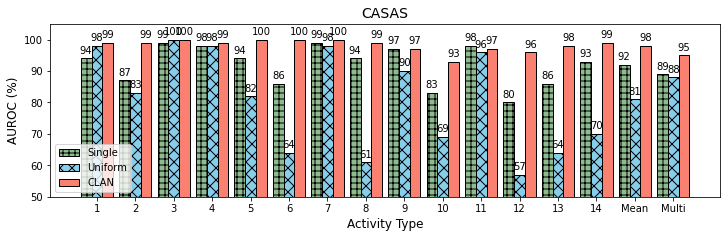

In [ ]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,7))
color_list = ['darkseagreen', 'skyblue', 'salmon']

# CA_ratio  = \
# np.array([[96, 94, 99], #1
#           [94, 87, 99], #2
#           [98, 99, 99], #3
#           [96, 98, 99], #4
#           [95, 94, 99], #5
#           [93, 86, 99], #6
#           [97, 99, 99], #7
#           [93, 94, 99], #8
#           [95, 97, 97], #9
#           [90, 83, 93], #10
#           [97, 98, 97], #11
#           [92, 80, 96], #12
#           [94, 86, 98], #13
#           [96, 93, 99], #14
#           [95, 92, 98], # Mean
#           [87, 89, 95]]) #Multi

ratio  = \
np.array([[94, 98, 99], #1
          [87, 83, 99], #2
          [99, 100, 100], #3
          [98, 98, 99], #4
          [94, 82, 100], #5
          [86, 64, 100], #6
          [99, 98, 100], #7
          [94, 61, 99], #8
          [97, 90, 97], #9
          [83, 69, 93], #10
          [98, 96, 97], #11
          [80, 57, 96], #12
          [86, 64, 98], #13
          [93, 70, 99], #14
          [92, 81, 98], # Mean
          [89, 88, 95]]) #Multi

type_d = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,'Mean','Multi']
values = {
    'Random': ratio[:,0],
    'Uniform': ratio[:,1],
    'CLAN':  ratio[:,2],
}

x = np.arange(len(type_d))  # the label locations
width = 0.28  # the width of the bars
multiplier = 0

plt.subplot(2, 1, 2)


for attribute, measurement in values.items():
    offset = width * multiplier
    # Apply the colormap directly to the bars
    rects = plt.bar(x + offset, measurement, width, label=attribute, color=color_list[multiplier], hatch=hatch_patterns[multiplier], edgecolor='black')
    plt.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel("AUROC (%)",fontsize=12)
plt.title('CASAS',fontsize=14)
plt.xlabel("Activity Type", fontsize=12)
plt.xticks(x + width, type_d)
plt.ylim(50, 105)
#plt.yticks([85, 90,95,100])
plt.legend(loc='lower left')
plt.show()

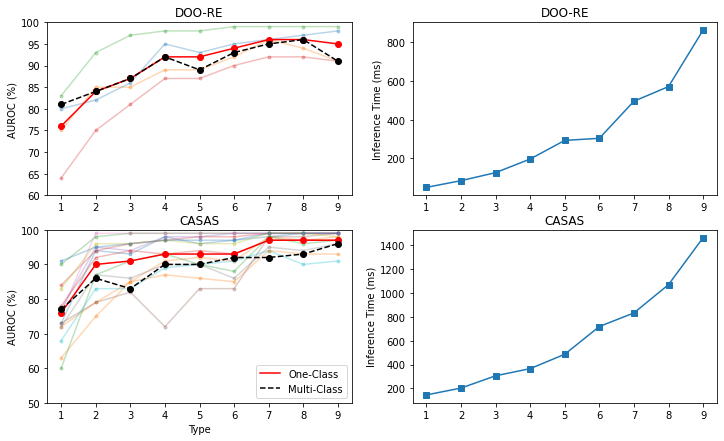

In [ ]:
# performance according to # 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.figure(figsize=(12,7))
ratio  = \
np.array([[80, 82, 86, 95, 93, 95, 96, 97, 98], #0
          [75, 85, 85, 89, 89, 92, 96, 94, 96], #1
          [83, 93, 97, 98, 98, 99, 99, 99, 99], #2
          [64, 75, 81, 87, 87, 90, 92, 92, 95], #3
          [76, 84, 87, 92, 92, 94, 96, 96, 97], #mean
          [81, 84, 87, 92, 89, 93, 95, 96, 97]]) #Multi


x = [round(num, 1) for num in range(1,10)]

plt.subplot(2, 2, 1)

for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3,\
         label=str(i))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean.One-Class')
plt.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Multi-class')

plt.title("DOO-RE")
plt.ylabel("AUROC (%)")
plt.ylim([60, 100])


plt.subplot(2, 2, 2)
time  = \
np.array([50.583, 85.264, 126.660, 196.951, 293.114, 304.058,  495.395, 570.937, 862.435])
plt.plot(x, time,  marker='s', linestyle='solid')
plt.title("DOO-RE")
plt.ylabel("Inference Time (ms)")


plt.subplot(2, 2, 3)
plt.title("CASAS")

CA_ratio  = \
np.array([[73, 94, 93, 98, 96, 97, 98, 99, 99], #1
          [72, 79, 85, 91, 92, 91, 98, 97, 98], #2
          [90, 98, 99, 99, 99, 99, 99, 99, 99], #3
          [84, 94, 96, 97, 98, 98, 99, 99, 99], #4
          [77, 95, 94, 98, 98, 99, 99, 99, 99], #5
          [73, 79, 82, 72, 83, 83, 98, 98, 99], #6
          [76, 99, 99, 99, 99, 99, 99, 99, 99], #7
          [72, 87, 86, 90, 90, 86, 95, 94, 96], #8
          [83, 96, 96, 97, 96, 96, 99, 99, 98], #9
          [68, 83, 83, 89, 90, 91, 94, 90, 91], #10
          [91, 95, 96, 97, 97, 97, 99, 99, 99], #11
          [63, 75, 85, 87, 86, 85, 94, 93, 93], #12
          [60, 87, 91, 93, 90, 88, 98, 96, 97], #13
          [78, 92, 94, 93, 94, 93, 97, 97, 97], #14
          [76, 90, 91, 93, 93, 93, 97, 97, 97], # Mean
          [77, 86, 83, 90, 90, 92, 92, 93, 96]]) #Multi

for i in range(14):
    plt.plot(x, CA_ratio[i], marker='.', alpha=0.3,\
         label=str(i))
    
plt.plot(x, CA_ratio[14], marker='o', linestyle='-', color ='red',\
         label='Mean.One-Class')
plt.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
         label= 'Multi-class')
plt.ylabel("AUROC (%)")
plt.xlabel("Type")
plt.ylim([50, 100])

red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')
plt.legend(handles=[red_line, black_line], loc ='lower right')

plt.subplot(2, 2, 4)
time  = \
np.array([145.989, 203.415, 306.014, 365.941, 485.867, 718.044,  831.776, 1068.255,  1460.8016])
plt.plot(x, time,  marker='s', linestyle='solid')
plt.title("CASAS")
plt.ylabel("Inference Time (ms)")


plt.show()

<Figure size 864x504 with 0 Axes>

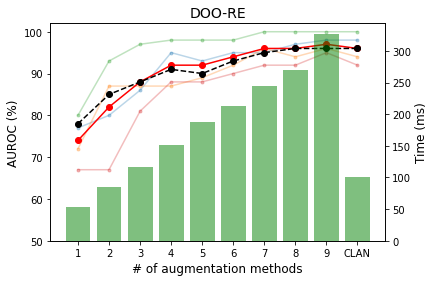

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
ratio  = \
np.array([[77, 80, 86, 95, 93, 95, 95, 97, 98, 98], #0
          [72, 87, 87, 87, 89, 92, 96, 94, 96, 94], #1
          [80, 93, 97, 98, 98, 98, 100, 100, 100, 100], #2
          [67, 67, 81, 88, 88, 90, 92, 92, 95, 92], #3
          [74, 82, 88, 92, 92, 94, 96, 96, 97, 96], #mean
          [78, 85, 88, 91, 90, 93, 95, 96, 96, 96]
          ]) #[81, 84, 87, 92, 89, 93, 95, 96, 97, 96] Multi


x = [str(num) if num != 10 else 'CLAN' for num in range(1, 11)]

plt.figure(figsize=(12,7))
# Create a figure and axis
fig, ax1 = plt.subplots()

for i in range(4):
    ax1.plot(x, ratio[i], marker='.', alpha=0.3,\
         label=str(i+1))
    
ax1.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean.One-Class')

ax1.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Mean.Multi-Class')

# Create the line graph on the primary y-axis
ax1.set_ylabel("AUROC (%)",fontsize=12)

ax1.set_xlabel('# of augmentation methods', fontsize=12)
#ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis on the right side for the bar graph
ax2 = ax1.twinx()
time  = \
np.array([53.25962181
, 84.91981917
, 116.3469503
, 151.1522799
, 188.4429775
, 213.5237576
, 244.1625961
, 270.381216
, 327.1201454
, 100.6196535
])
ax1.set_ylim([50, 102])
ax2.bar(x, time, color='g', alpha=0.5, label='Inference Time')
ax2.set_ylabel('Time (ms)',fontsize=12)
ax2.set_xticks(x, fontsize=12)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.6, 0.8),fontsize=12)

# Show the plot
plt.title('DOO-RE',fontsize=14)
plt.show()

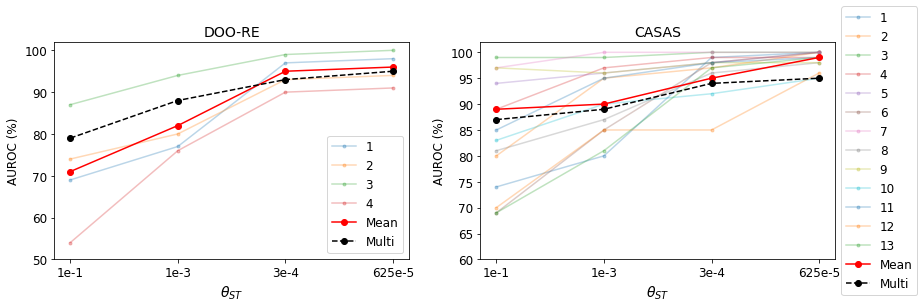

In [ ]:

# performance according to # 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
ratio  = \
np.array([[69, 77, 97, 98], #0
          [74, 80, 93, 94], #1
          [87, 94, 99, 100], #2
          [54, 76, 90, 91], #3
          [71, 82, 95, 96],
          [79, 88, 93, 95]]) #Multi

x = ['1e-1', '1e-3', '3e-4', '625e-5']

plt.title("DOO-RE",fontsize=14)
for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3, label=str(i+1))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean')
plt.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Multi')

plt.ylabel("AUROC (%)",fontsize=12)
plt.xticks(x,fontsize=12)
#plt.xlabel(r"${\theta_{ST}}$")
plt.ylim([50, 102])
plt.yticks(fontsize=12)
plt.xlabel(r"${\theta_{ST}}$",fontsize=14)
plt.legend(fontsize=12)
#plt.subplots_adjust(left=0.1, right=0.75)  # Adjust left and right margins for the legend


plt.subplot(1, 2, 2)
plt.title("CASAS",fontsize=14)

CA_ratio  = \
np.array([[74, 80, 99, 100], #1
          [80, 95, 97, 100], #2
          [99, 99, 100, 100], #3
          [89, 97, 99, 99], #4
          [94, 96, 98, 100], #5
          [69, 85, 98, 100], #6
          [97, 100, 100, 100], #7
          [81, 87, 96, 98], #8
          [97, 96, 98, 98], #9
          [83, 90, 92, 95], #10
          [85, 95, 98, 99], #11
          [70, 85, 85, 96], #12
          [69, 81, 97, 99], #13
          [89, 90, 95, 99], #14
          [84, 91, 96.6, 98.7], # Mean
          [87, 89, 94, 95] #Multi
])

for i in range(13):
    plt.plot(x, CA_ratio[i], marker='.', alpha=0.3,\
         label=str(i+1))
    
plt.plot(x, CA_ratio[13], marker='o', linestyle='-', color ='red',\
         label='Mean')
plt.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
         label= 'Multi')
plt.ylabel("AUROC (%)", fontsize=12)
plt.xlabel(r"${\theta_{ST}}$",fontsize=14)
plt.ylim([60, 102])
plt.xticks(x,fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
# red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
# black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')

#plt.legend(handles=[red_line, black_line], loc ='lower right',fontsize=14)


plt.show()

<Figure size 864x360 with 0 Axes>

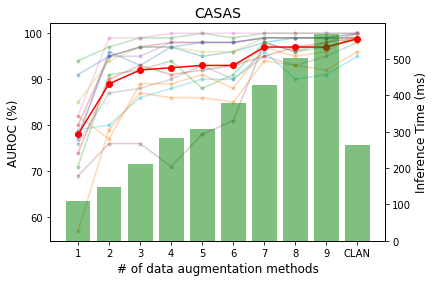

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
CA_ratio  = \
np.array([[77, 96, 93, 97, 95,   96, 98, 99, 99, 100], #1
          [82, 77, 89, 89, 91,  88, 97, 95, 96, 100], #2
          [94, 97, 99, 99, 100, 99, 100, 100, 100, 100], #3
          [80, 95, 97, 98, 98,  98, 99, 99, 99, 99], #4
          [78, 95, 95, 98, 98,  98, 99, 99, 99, 100], #5
          [69, 76, 76, 71, 78,  81, 98, 96, 98, 100], #6
          [82, 99, 99, 100, 100,100, 100, 100, 100, 100], #7
          [76, 87, 88, 90, 93,  90, 95, 93, 95, 98], #8
          [85, 94, 97, 97, 96,  96, 99, 99, 99, 98], #9
          [79, 80, 86, 88, 90,  90, 96, 90, 91, 95], #10
          [91, 95, 97, 97, 98,  98, 99, 99, 99, 99], #11
          [57, 79, 87, 86, 86,  85, 94, 93, 92, 96], #12
          [71, 91, 92, 94, 88,  91, 98, 96, 97, 99], #13
          [74, 90, 93, 91, 92,  93, 95, 97, 98, 99], #14
          [78, 89, 92, 92.5,93, 93, 97, 97, 97, 98.8]]) #Mean


x = [str(num) if num != 10 else 'CLAN' for num in range(1, 11)]

plt.figure(figsize=(12,5))
# Create a figure and axis
fig, ax1 = plt.subplots()

for i in range(14):
    ax1.plot(x, CA_ratio[i], marker='.', alpha=0.3,\
         label=str(i+1))
    
ax1.plot(x, CA_ratio[14], marker='o', linestyle='-', color ='red',\
         label='Mean')
#ax1.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
#         label= 'Mean.Multi-Class')

# Create the line graph on the primary y-axis
ax1.set_ylabel("AUROC (%)",fontsize=12)
#ax1.set_yticks([60,70, 80, 90,100],fontsize=12)
ax1.set_xlabel('# of data augmentation methods',fontsize=12)
#ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis on the right side for the bar graph
ax2 = ax1.twinx()
time  = \
np.array([108.4541964
, 148.1707239
, 210.9591496
, 281.8072168
, 307.4077982
, 378.3939817
,  429.0384275
, 503.42709
,  569.2639934
,263.5891185
])

ax2.bar(x, time, color='g', alpha=0.5, label='Time')
ax2.set_ylabel('Inference Time (ms)',fontsize=12)
ax2.set_xticks(x,fontsize=12)
# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.15, 1.05),fontsize=11)

# Show the plot
plt.title('CASAS',fontsize=14)
plt.show()

<Figure size 864x360 with 0 Axes>

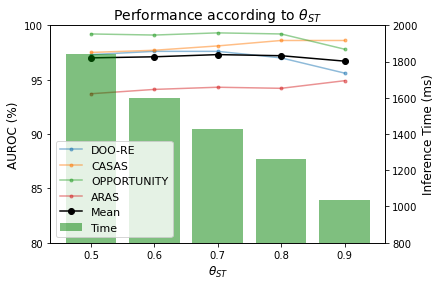

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))

x = ['0.5', '0.6', '0.7', '0.8', '0.9']
dataset_lis = ['DOO-RE','CASAS','OPPORTUNITY', 'ARAS']
# Sample data
ratio  = \
np.array([[97.3, 97.6, 97.6, 97.0, 95.6], #DOO-RE
          [97.5, 97.7, 98.1, 98.6, 98.6], #CASS
          [99.2, 99.1, 99.3, 99.2, 97.8], #OPP
          [93.7, 94.1, 94.3, 94.2, 94.9], #ARAS
          [97.0, 97.1, 97.3, 97.2, 96.7]]) #Mean

# Create a figure and axis
fig, ax1 = plt.subplots()
ax1.set_title('Performance according to '+ r"${\theta_{ST}}$",fontsize=14)
for i in range(4):
    ax1.plot(x, ratio[i], marker='.', alpha=0.5,\
         label=dataset_lis[i])
    
ax1.plot(x, ratio[4], marker='o', linestyle='-', color ='black',\
         label='Mean')
#ax1.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
#         label= 'Mean.Multi-Class')
ax1.set_ylim([80,100])
ax1.set_yticks([80,85,90,95,100])
# Create the line graph on the primary y-axis
ax1.set_ylabel("AUROC (%)",fontsize=12)

ax1.set_xlabel(r"${\theta_{ST}}$",fontsize=12)
#ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis on the right side for the bar graph
ax2 = ax1.twinx()
time  = \
np.array([1842.44158,1600.976139,1425.890336,1261.84978,1036.663336])

ax2.bar(x, time, color='g', alpha=0.5, label='Time')
ax2.set_ylabel('Inference Time (ms)',fontsize=12)
ax2.set_xticks(x,fontsize=12)
ax2.set_ylim([800,2000])
# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize=11, loc ='lower left')

# Show the plot

plt.show()

In [ ]:
# performance according to # 
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
x = [0.6, 0.7, 0.8, 0.9]

fig, ax1 = plt.subplots()
plt.title("CASAS",fontsize=14)

CA_ratio  = \
np.array([[74, 80, 99, 100], #1
          [80, 95, 97, 100], #2
          [99, 99, 100, 100], #3
          [89, 97, 99, 99], #4
          [94, 96, 98, 100], #5
          [69, 85, 98, 100], #6
          [97, 100, 100, 100], #7
          [81, 87, 96, 98], #8
          [97, 96, 98, 98], #9
          [83, 90, 92, 95], #10
          [85, 95, 98, 99], #11
          [70, 85, 85, 96], #12
          [69, 81, 97, 99], #13
          [89, 90, 95, 99], #14
          [84, 91, 96.6, 98.7], # Mean
          [87, 89, 94, 95] #Multi
])

for i in range(13):
    ax1.plot(x, CA_ratio[i], marker='.', alpha=0.3,\
         label=str(i+1))
    
ax1.plot(x, CA_ratio[13], marker='o', linestyle='-', color ='red',\
         label='Mean')
#ax1.plot(x, CA_ratio[15], marker='o', linestyle='--', color ='black',\
#         label= 'Multi')
ax1.set_ylabel("AUROC (%)", fontsize=12)
ax1.set_xlabel(r"${\theta_{ST}}$",fontsize=12)
ax1.set_ylim([60, 102])
ax1.set_xticks(x,fontsize=12)
ax1.set_yticks([60,70,80,90,100],fontsize=12)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=11)
# red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
# black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')

# plt.legend(handles=[red_line, black_line], loc ='lower right',fontsize=14)


plt.show()

IndentationError: unexpected indent (<ipython-input-43-f3d0543e289b>, line 37)

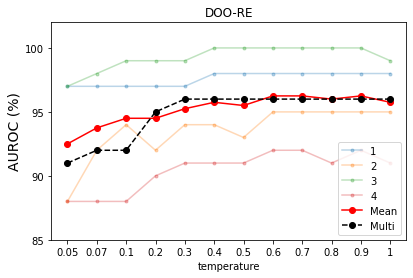

In [ ]:
# performance temp and lambda 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)

ratio  = \
np.array([[97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98], #0
          [88, 92, 94, 92, 94, 94, 93, 95, 95, 95, 95, 95], #1
          [97, 98, 99, 99, 99,100,100,100,100,100,100, 99], #2
          [88, 88, 88, 90, 91, 91, 91, 92, 92, 91, 92, 91], #3
          [92.5, 93.75, 94.5, 94.5, 95.25, 95.75, 95.5, 96.25, 96.25, 96, 96.25, 95.75],
          [91, 92, 92, 95, 96, 96, 96, 96, 96, 96, 96, 96]]) #Multi


x = ['0.05', '0.07', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3,\
         label=str(i+1))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean')
plt.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Multi')


plt.title("DOO-RE")
plt.xlabel("temperature")
plt.ylabel("AUROC (%)",fontsize=14)
plt.ylim([85, 102])
#plt.legend()

y_ticks = np.arange(85, 102, 5)
plt.yticks(y_ticks)
red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')
#plt.legend(handles=[red_line, black_line], loc ='lower right', fontsize=12)
plt.legend()


plt.show()


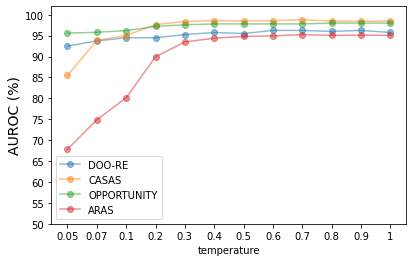

In [ ]:
# performance temp and lambda 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
dataset_list = ['DOO-RE','CASAS','OPPORTUNITY', 'ARAS']

plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
ratio  = \
np.array([[92.5, 93.75, 94.5, 94.5, 95.25, 95.75, 95.5, 96.25, 96.25, 96, 96.25, 95.75],
          [85.47, 93.86, 95, 97.64, 98.36, 98.6, 98.5, 98.57, 98.79, 98.5, 98.43, 98.5],
          [95.6, 95.8, 96.2, 97.2, 97.6, 97.8, 97.8, 97.8, 97.8, 98, 98, 98 ],
        [67.81, 74.88, 80.13, 89.94,93.5, 94.38, 94.81, 94.94, 95.25, 95.06, 95.13, 95.06]        
        ]) #Multi

x = ['0.05', '0.07', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
for i in range(4):
    plt.plot(x, ratio[i], marker='o', alpha=0.5,\
         label=dataset_list[i])


#plt.title("DOO-RE")
plt.xlabel("temperature")
plt.ylabel("AUROC (%)",fontsize=14)
plt.ylim([85, 102])
#plt.legend()

y_ticks = np.arange(50, 102, 5)
plt.yticks(y_ticks)
# red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
# black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')
#plt.legend(handles=[red_line, black_line], loc ='lower right', fontsize=12)
plt.legend()


plt.show()


Text(0.5, 1.0, 'ARAS (T)')

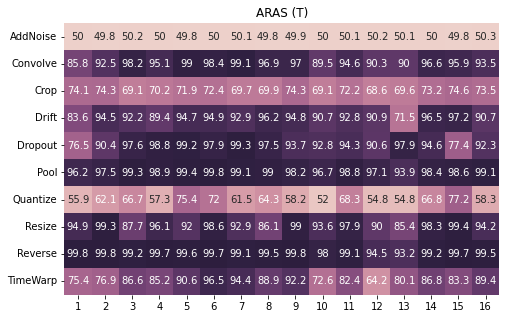

In [ ]:
import matplotlib.pyplot as plt
import seaborn
data = [[0.500468158,   0.498253779,	0.501606997,	0.500076894,	0.497680185,	0.499747374,	0.501023499,	0.497584652,	0.499154171,	0.499503883,	0.501455148,	0.502197678,	0.500572042,	0.499537086,	0.497503683,	0.503037293],
[0.858276847, 0.925335302,  0.981807705,	0.950634371,	0.990187943,	0.984342468,	0.99068812,	0.968778931,	0.970203768,	0.895398078,	0.945823499,	0.903220638,	0.900441599,	0.966322983,	0.959164537,	0.935447905],
[0.741444683, 0.742941622,  0.691058278,	0.701518647,	0.718558293,	0.72373381,	0.697112534,	0.699046513,	0.743271819,	0.690802983,	0.721947451,	0.685787597,	0.695782353,	0.731573933,	0.746185244,	0.73467897],
[0.836063591, 0.945429327,	0.922188466,	0.893925413,	0.947270557,	0.948870096,	0.929471588,	0.962109758,	0.947866205,	0.907332872,	0.92796752,	0.908593126,	0.714515955,	0.965485321,	0.97199331,	0.907381776],
[0.764557209, 0.903934256,	0.975566528,	0.988119954,	0.992418624,	0.978683806,	0.993395125,	0.975392149,	0.936582084,	0.928155087,	0.942554594,	0.906045513,	0.979343622,	0.946083706,	0.774075425,	0.923125721],
[0.962125752, 0.97488729,	0.993187159,    0.989004229,	0.993554156,	0.99830679,	0.990652395,	0.990462884,	0.981737793,	0.966975025,	0.988342484,	0.970697762,	0.939456917,	0.983624022,	0.985572764,	0.990695886],
[0.559447735, 0.620562968,	0.666571027,	0.572818147,	0.754112357,	0.72025178,	0.615109358,	0.642709481,	0.582237601,	0.520440646,	0.683457578,	0.547705021,	0.548200892,	0.668332626,	0.772431403,	0.582852749],
[0.949192895, 0.993325413,	0.876935163,	0.96070742,	0.919820761,	0.986406167,	0.929412949,	0.861471326,	0.989504037,	0.935785406,	0.979105944,	0.899950388,	0.854457424,	0.983401492,	0.993585221,	0.942137639],
[0.998169704, 0.9983198,	0.992372411,	0.996616686,	0.996065236,	0.996938824,	0.991402307,	0.994953772,	0.998116109,	0.979621284,	0.991292787,	0.945384491,	0.931921538,	0.991839585,	0.9967996,	0.994963476],
[0.753787297, 0.768915694,	0.866324275,	0.85159554,	0.90606925,	0.964581238,	0.9444002,	0.88902253,	0.921683968,	0.725979239,	0.824136624,	0.641635017,	0.800570211,	0.868361907,	0.832771534,	0.893656286]
]       
y_lab =['AddNoise', 'Convolve','Crop','Drift','Dropout','Pool','Quantize','Resize','Reverse','TimeWarp']
data = [[element * 100 for element in sublist] for sublist in data]

fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=y_lab, xticklabels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))

    # Save Figure
plt.title(u'ARAS (T)')

Text(0.5, 1.0, 'ARAS (F)')

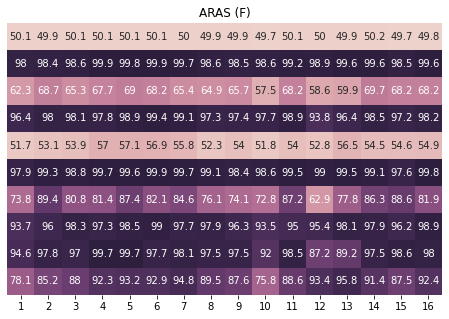

In [ ]:
import matplotlib.pyplot as plt
import seaborn
data = [[50.1,	49.9,	50.1,	50.1,	50.1,	50.1,	50.0,	49.9,	49.9,	49.7,	50.1,	50.0,	49.9,	50.2,	49.7,	49.8],
[98.0,	98.4,	98.6,	99.9,	99.8,	99.9,	99.7,	98.6,	98.5,	98.6,	99.2,	98.9,	99.6,	99.6,	98.5,	99.6],
[62.3,	68.7,	65.3,	67.7,	69.0,	68.2,	65.4,	64.9,	65.7,	57.5,	68.2,	58.6,	59.9,	69.7,	68.2,	68.2],
[96.4,	98.0,	98.1,	97.8,	98.9,	99.4,	99.1,	97.3,	97.4,	97.7,	98.9,	93.8,	96.4,	98.5,	97.2,	98.2],
[51.7,	53.1,	53.9,	57.0,	57.1,	56.9,	55.8,	52.3,	54.0,	51.8,	54.0,	52.8,	56.5,	54.5,	54.6,	54.9],
[97.9,	99.3,	98.8,	99.7,	99.6,	99.9,	99.7,	99.1,	98.4,	98.6,	99.5,	99.0,	99.5,	99.1,	97.6,	99.8],
[73.8,	89.4,	80.8,	81.4,	87.4,	82.1,	84.6,	76.1,	74.1,	72.8,	87.2,	62.9,	77.8,	86.3,	88.6,	81.9],
[93.7,	96.0,	98.3,	97.3,	98.5,	99.0,	97.7,	97.9,	96.3,	93.5,	95.0,	95.4,	98.1,	97.9,	96.2,	98.9],
[94.6,	97.8,	97.0,	99.7,	99.7,	97.7,	98.1,	97.5,	97.5,	92.0,	98.5,	87.2,	89.2,	97.5,	98.6,	98.0],
[78.1,	85.2,	88.0,	92.3,	93.2,	92.9,	94.8,	89.5,	87.6,	75.8,	88.6,	93.4,	95.8,	91.4,	87.5,	92.4]
]       

fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=False, xticklabels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'ARAS (F)')

Text(0.5, 1.0, 'DOO-RE (F)')

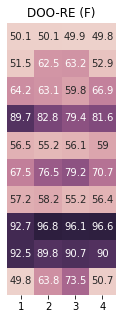

In [ ]:
data = [[50.1,	50.1,	49.9,	49.8],
[51.5,	62.5,	63.2,	52.9],
[64.2,	63.1,	59.8,	66.9],
[89.7,	82.8,	79.4,	81.6],
[56.5,	55.2,	56.1,	59.0],
[67.5,	76.5,	79.2,	70.7],
[57.2,	58.2,	55.2,	56.4],
[92.7,	96.8,	96.1,	96.6],
[92.5,	89.8,	90.7,	90.0],
[49.8,	63.8,	73.5,	50.7]]

fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=False, xticklabels=[1,2,3,4], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'DOO-RE (F)')



Text(0.5, 1.0, 'DOO-RE (T)')

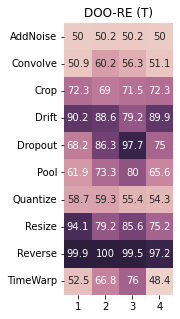

In [3]:
import matplotlib.pyplot as plt
import seaborn
data = [[50.0,	50.2,	50.2,	50.0],
[50.9,	60.2,	56.3,	51.1],
[72.3,	69.0,	71.5,	72.3],
[90.2,	88.6,	79.2,	89.9],
[68.2,	86.3,	97.7,	75.0],
[61.9,	73.3,	80.0,	65.6],
[58.7,	59.3,	55.4,	54.3],
[94.1,	79.2,	85.6,	75.2],
[99.9,	100.0,	99.5,	97.2],
[52.5,	66.8,	76.0,	48.4]]
y_lab =['AddNoise', 'Convolve','Crop','Drift','Dropout','Pool','Quantize','Resize','Reverse','TimeWarp']
fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=y_lab, xticklabels=[1,2,3,4], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'DOO-RE (T)')


Text(0.5, 1.0, 'CASAS (F)')

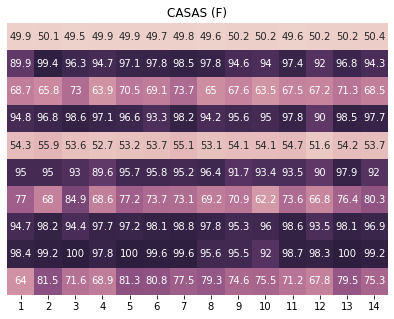

In [11]:
import matplotlib.pyplot as plt
import seaborn
data = [[49.9,	50.1,	49.5,	49.9,	49.9,	49.7,	49.8,	49.6,	50.2,	50.2,	49.6,	50.2,	50.2,	50.4],
[89.9,	99.4,	96.3,	94.7,	97.1,	97.8,	98.5,	97.8,	94.6,	94.0,	97.4,	92.0,	96.8,	94.3],
[68.7,	65.8,	73.0,	63.9,	70.5,	69.1,	73.7,	65.0,	67.6,	63.5,	67.5,	67.2,	71.3,	68.5],
[94.8,	96.8,	98.6,	97.1,	96.6,	93.3,	98.2,	94.2,	95.6,	95.0,	97.8,	90.0,	98.5,	97.7],
[54.3,	55.9,	53.6,	52.7,	53.2,	53.7,	55.1,	53.1,	54.1,	54.1,	54.7,	51.6,	54.2,	53.7],
[95.0,	95.0,	93.0,	89.6,	95.7,	95.8,	95.2,	96.4,	91.7,	93.4,	93.5,	90.0,	97.9,	92.0],
[77.0,	68.0,	84.9,	68.6,	77.2,	73.7,	73.1,	69.2,	70.9,	62.2,	73.6,	66.8,	76.4,	80.3],
[94.7,	98.2,	94.4,	97.7,	97.2,	98.1,	98.8,	97.8,	95.3,	96.0,	98.6,	93.5,	98.1,	96.9],
[98.4,	99.2,	100.0,	97.8,	100.0,	99.6,	99.6,	95.6,	95.5,	92.0,	98.7,	98.3,	100.0,	99.2],
[64.0,	81.5,	71.6,	68.9,	81.3,	80.8,	77.5,	79.3,	74.6,	75.5,	71.2,	67.8,	79.5,	75.3]
]

fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=False, xticklabels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'CASAS (F)')


Text(0.5, 1.0, 'CASAS (T)')

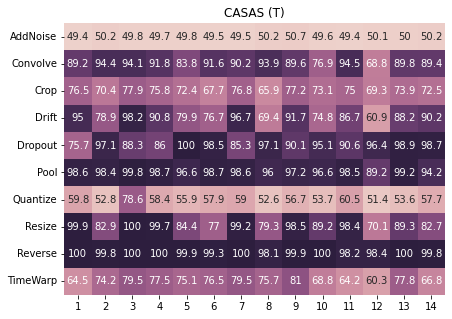

In [7]:
import matplotlib.pyplot as plt
import seaborn
data = [[49.4,	50.2,	49.8,	49.7,	49.8,	49.5,	49.5,	50.2,	50.7,	49.6,	49.4,	50.1,	50.0,	50.2],
[89.2,	94.4,	94.1,	91.8,	83.8,	91.6,	90.2,	93.9,	89.6,	76.9,	94.5,	68.8,	89.8,	89.4],
[76.5,	70.4,	77.9,	75.8,	72.4,	67.7,	76.8,	65.9,	77.2,	73.1,	75.0,	69.3,	73.9,	72.5],
[95.0,	78.9,	98.2,	90.8,	79.9,	76.7,	96.7,	69.4,	91.7,	74.8,	86.7,	60.9,	88.2,	90.2],
[75.7,	97.1,	88.3,	86.0,	100.0,	98.5,	85.3,	97.1,	90.1,	95.1,	90.6,	96.4,	98.9,	98.7],
[98.6,	98.4,	99.8,	98.7,	96.6,	98.7,	98.6,	96.0,	97.2,	96.6,	98.5,	89.2,	99.2,	94.2],
[59.8,	52.8,	78.6,	58.4,	55.9,	57.9,	59.0,	52.6,	56.7,	53.7,	60.5,	51.4,	53.6,	57.7],
[99.9,	82.9,	100.0,	99.7,	84.4,	77.0,	99.2,	79.3,	98.5,	89.2,	98.4,	70.1,	89.3,	82.7],
[100.0,	99.8,	100.0,	100.0,	99.9,	99.3,	100.0,	98.1,	99.9,	100.0,	98.2,	98.4,	100.0,	99.8],
[64.5,	74.2,	79.5,	77.5,	75.1,	76.5,	79.5,	75.7,	81.0,	68.8,	64.2,	60.3,	77.8,	66.8]
]
y_lab =['AddNoise', 'Convolve','Crop','Drift','Dropout','Pool','Quantize','Resize','Reverse','TimeWarp']
fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=y_lab, xticklabels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'CASAS (F)')


Text(0.5, 1.0, 'OPPORTUNITY (T)')

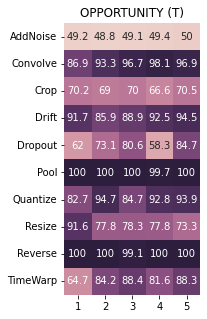

In [15]:
import matplotlib.pyplot as plt
import seaborn
data = [[49.2,	48.8,	49.1,	49.4,	50.0],
[86.9,	93.3,	96.7,	98.1,	96.9],
[70.2,	69.0,	70.0,	66.6,	70.5],
[91.7,	85.9,	88.9,	92.5,	94.5],
[62.0,	73.1,	80.6,	58.3,	84.7],
[100.0,	100.0,	100.0,	99.7,	100.0],
[82.7,	94.7,	84.7,	92.8,	93.9],
[91.6,	77.8,	78.3,	77.8,	73.3],
[100.0,	100.0,	99.1,	100.0,	100.0],
[64.7,	84.2,	88.4,	81.6,	88.3]]
y_lab =['AddNoise', 'Convolve','Crop','Drift','Dropout','Pool','Quantize','Resize','Reverse','TimeWarp']
fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=y_lab, xticklabels=[1,2,3,4,5], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'OPPORTUNITY (T)')


Text(0.5, 1.0, 'OPPORTUNITY (T)')

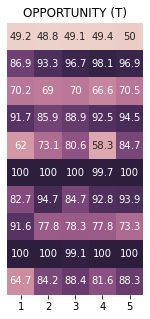

In [16]:
import matplotlib.pyplot as plt
import seaborn
data = [[49.2,	48.8,	49.1,	49.4,	50.0],
[86.9,	93.3,	96.7,	98.1,	96.9],
[70.2,	69.0,	70.0,	66.6,	70.5],
[91.7,	85.9,	88.9,	92.5,	94.5],
[62.0,	73.1,	80.6,	58.3,	84.7],
[100.0,	100.0,	100.0,	99.7,	100.0],
[82.7,	94.7,	84.7,	92.8,	93.9],
[91.6,	77.8,	78.3,	77.8,	73.3],
[100.0,	100.0,	99.1,	100.0,	100.0],
[64.7,	84.2,	88.4,	81.6,	88.3]]
fig, axs = plt.subplots(1,1, figsize=(30, 5))
seaborn.heatmap(data, square=True, cbar=False, yticklabels=False, xticklabels=[1,2,3,4,5], annot=True,  fmt=".3g",  cmap=seaborn.cubehelix_palette(as_cmap=True))
    # Save Figure
plt.title(u'OPPORTUNITY (F)')

/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/juice/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 516 samples in 0.002s...
[t-SNE] Computed neighbors for 516 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 516 / 516
[t-SNE] Mean sigma: 14.606179
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.346939
[t-SNE] KL divergence after 1000 iterations: 0.577864
['1', '2', '3', '4']


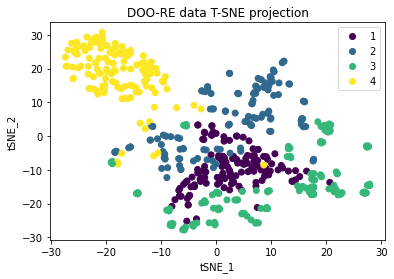

In [ ]:
tsne_visualization(datalist_DR.cpu(), labellist_DR, 'DOO-RE', 3)

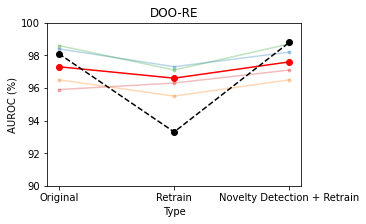

In [ ]:
# performance according to # 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

ratio  = \
np.array([[98.4, 97.3, 98.2], #0
          [96.5,95.5,96.5], #1
          [98.6,97.1, 98.7], #2
          [95.9, 96.3, 97.1], #3
          [97.3, 96.6, 97.6],
          [98.1, 93.3, 98.8]]) #Multi


x = ['Original', 'Retrain', 'Novelty Detection + Retrain']
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)

for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3,\
         label=str(i))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean.One-Class')
plt.plot(x, ratio[5], marker='o', linestyle='--', color ='black',\
         label= 'Multi-class')


plt.title("DOO-RE")
plt.xlabel("Type")
plt.ylabel("AUROC (%)")
plt.ylim([90, 100])
#plt.legend()


plt.show()


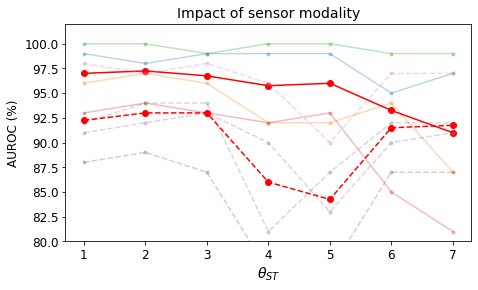

In [18]:
# performance according to # 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



plt.figure(figsize=(16,4))
plt.subplot(1, 2, 1)

plt.title("Impact of sensor modality",fontsize=14)
ratio  = \
np.array([[99, 98, 99, 99, 99, 95, 97], #0
          [96, 97, 96, 92, 92, 94, 87], #1
          [100, 100, 99, 100, 100, 99, 99], #2
          [93, 94, 93, 92, 93, 85, 81], #3
          [97, 97.25, 96.75, 95.75, 96, 93.25, 91]]) #Multi

x = ['Brightness', 'Existence', 'Light', 'Seat Occupy','Sound', 'Projector', 'Presentation']
x = ['1', '2', '3', '4', '5', '6','7']

for i in range(4):
    plt.plot(x, ratio[i], marker='.', alpha=0.3, label=str(i+1))
    
plt.plot(x, ratio[4], marker='o', linestyle='-', color ='red',\
         label='Mean')

ratio_2  = \
np.array([[91, 92, 93, 90, 91, 83, 90  ], #0
          [88, 89, 87, 87, 87, 77, 77  ], #1
          [98, 97, 98, 97, 97, 90, 96 ], #2
          [92, 94, 94, 92, 92, 87, 81 ], #3
          [92.25, 93, 93, 91.5, 91.75, 84.25, 86]]) #Multi

for i in range(4):
    plt.plot(x, ratio_2[i], marker='.', linestyle='--', alpha=0.3, label=str(i+1))
    
plt.plot(x, ratio_2[4], marker='o', linestyle='--', color ='red',\
         label='Mean')

plt.ylabel("AUROC (%)",fontsize=12)
plt.xticks(x,fontsize=12)
#plt.xlabel(r"${\theta_{ST}}$")
plt.ylim([80, 102])
plt.yticks(fontsize=12)
plt.xlabel(r"${\theta_{ST}}$",fontsize=14)
#plt.legend(fontsize=12)
#plt.subplots_adjust(left=0.1, right=0.75)  # Adjust left and right margins for the legend



# red_line = mlines.Line2D([], [], color='red', linestyle ='-', label='One-Class')
# black_line = mlines.Line2D([], [], color='black', linestyle ='--', label='Multi-Class')

# plt.legend(handles=[red_line, black_line], loc ='lower right',fontsize=14)


plt.show()

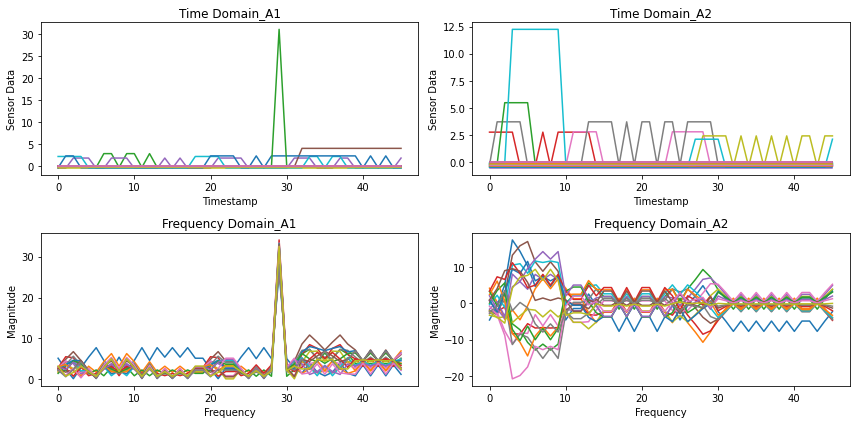

In [ ]:
# Visualization for CASAS
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_CS[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_CS[317].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")



# 주파수 도메인 데이터 시각화
freq_data_1 = np.abs(np.fft.rfft((input_data_1)))
freq_data_2 = np.fft.rfft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()


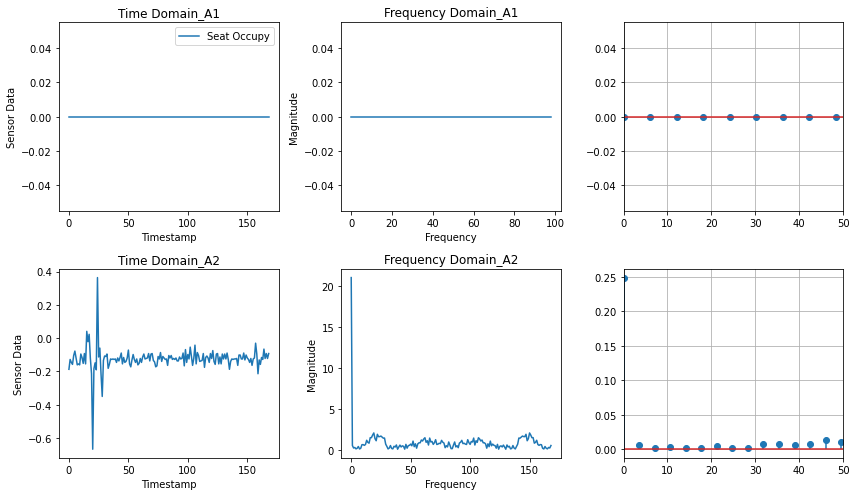

In [ ]:
# Visualization for Opportunity
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


channel_num  = 150
# 입력 데이터 생성
input_data_1 = datalist_OP[30][:200 , channel_num ].cpu().numpy()  # Activity 1

#99

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")
# 주파수 도메인 데이터 시각화
freq_data_1 = np.abs(np.fft.fftn(input_data_1[1:100]))
amb = freq_data_1 * (2/len(freq_data_1))
freqqq= np.fft.fftfreq(len(freq_data_1), 1/598)


plt.subplot(2, 3, 2)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


plt.subplot(2, 3, 3)
plt.xlim(0,50)
plt.stem(freqqq, amb)
plt.grid(True)

input_data_2 = datalist_OP[20][:300, channel_num  ].cpu().numpy()  # Activity 2

# # 주파수 도메인 데이터 시각화
freq_data_2 = np.abs(np.fft.fftn(input_data_2[0:300]))
amb = freq_data_2 * (2/len(freq_data_2))
freqqq_2= np.fft.fftfreq(len(freq_data_2), 1/598)


plt.subplot(2, 3, 4)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 5)
plt.plot(freq_data_2[:])
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 6)
plt.xlim(0,50)
plt.stem(freqqq_2, amb)
plt.grid(True)




plt.tight_layout()
plt.show()

In [ ]:
# Visualization for ARAS_A
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_AA[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_AA[70].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")



# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.fft((input_data_1[:200 , : ]))
freq_data_2 = np.fft.fft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for ARAS_B
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_AB[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_AB[50].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.fft((input_data_1[:200 , : ]))
freq_data_2 = np.fft.fft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for ARAS_B
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *


# 입력 데이터 생성
input_data_1 = datalist_AB[30][:200 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_AB[50].cpu().numpy()  # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
print(datalist_AB.shape)
freq_data_1 = np.fft.fft((datalist_AB), axis=0)
print(freq_data_1)
freq_data_2 = np.fft.fft((input_data_2), axis=0)

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
# Visualization for different augmentations
import numpy as np
import torch
import matplotlib.pyplot as plt
from tsaug import *
from data_preprocessing.augmentations import PERMUTE


# 입력 데이터 생성
input_data_1 = datalist_DR[336][:300 , ].cpu().numpy()  # Activity 1
print(input_data_1.shape)
my_augmenter = (  (AddNoise(scale=0.05))# random time warping 5 times in parallel
                #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                #+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
                #+ Reverse() @ 0.2  # with 50% probability, reverse the sequence
                )
input_data_2  = my_augmenter.augment(np.reshape(input_data_1,(1, input_data_1.shape[0], -1)))[0]

my_augmenter = PERMUTE(min_segments=2, max_segments=15, seg_mode="random")
#input_data_3  = np.reshape(my_augmenter.augment(np.reshape(input_data_1,(1, input_data_1.shape[1], -1)))[0], (input_data_1.shape[0], -1))

#input_data_3 = scaling(np.reshape(input_data_1 ,(1, input_data_1.shape[0], -1)), sigma=0.1)[0] # same as the add noise
input_data_3 = my_augmenter.augment(np.reshape(input_data_1 ,(1, input_data_1.shape[0], -1)))[0]

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 3)
plt.plot(input_data_3)
plt.title("Time Domain_A3")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")
#plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 

# 주파수 도메인 데이터 시각화
print(np.transpose(input_data_1).shape)
freq_data_1 = np.fft.fft(np.transpose(input_data_1))
my_augmenter = (  Reverse()# random time warping 5 times in parallel
                #+ Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
                #+ Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
                #+ Reverse() @ 0.2  # with 50% probability, reverse the sequence
                )
freq_data_2 = np.fft.fft(input_data_1.T).T

#freq_data_2 = np.fft.rfft(input_data_2, axis=0)
freq_data_3 = np.fft.fft(input_data_1)

plt.subplot(2, 3, 4)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 5)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 6)
plt.plot(freq_data_3)
plt.title("Frequency Domain_A3")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


#plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 
plt.tight_layout()
plt.show()


In [ ]:
# Visualization for different activities
import numpy as np
import matplotlib.pyplot as plt
from tsaug import *

# [119, 52, 40, 129]

# 입력 데이터 생성
input_data_1 = datalist_DR[30][:100 , : ].cpu().numpy()  # Activity 1
input_data_2 = datalist_DR[339][:200 , : ].cpu().numpy()
input_data_3 = datalist_DR[170][:200 , : ].cpu().numpy()

#input_data_2 = scaling(np.reshape(input_data_1 ,(1, input_data_1.shape[0], -1)), sigma=0.1)[0] # same as the add noise


# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 3, 3)
plt.plot(input_data_3)
plt.title("Time Domain_A3")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
freq_data_1 = np.fft.rfft(input_data_1, axis=0)
freq_data_2 = np.fft.rfft(input_data_2, axis=0)
freq_data_3 = np.fft.rfft(input_data_3, axis=0)

plt.subplot(2, 3, 4)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 5)
plt.plot(freq_data_2)
plt.title("Frequency Domain_A2")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 3, 6)
plt.plot(freq_data_3)
plt.title("Frequency Domain_A3")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


plt.legend(['Seat Occupy', 'Sound', 'Brightness', 'Light', 'Existence', 'Projector', 'Presentation']) 
plt.tight_layout()
plt.show()

In [ ]:
# DOO-RE
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#0
x_res = np.array([
[0.603	,0.538	,0.553	,0.641	,0.539	,0.529	,0.520	,0.569	,0.521	,0.566],
[0.649	,0.560	,0.563	,0.564	,0.582	,0.697	,0.637	,0.536	,0.485	,0.542],
[0.888	,0.893	,0.570	,0.919	,0.888	,0.894	,0.887	,0.905	,0.725	,0.915],
[0.933	,0.943	,0.790	,0.292	,0.946	,0.951	,0.917	,0.891	,0.496	,0.900],
[0.766	,0.635	,0.747	,0.841	,0.469	,0.800	,0.702	,0.696	,0.477	,0.666],
[0.502	,0.650	,0.571	,0.518	,0.701	,0.618	,0.511	,0.630	,0.576	,0.642],
[0.572	,0.727	,0.623	,0.539	,0.754	,0.721	,0.596	,0.668	,0.502	,0.550],
[0.790	,0.791	,0.731	,0.931	,0.916	,0.745	,0.838	,0.648	,0.821	,0.689],
[0.952	,0.951	,0.926	,0.975	,0.943	,0.952	,0.953	,0.959	,0.503	,0.945],
[0.650	,0.613	,0.580	,0.688	,0.610	,0.618	,0.639	,0.624	,0.551	,0.563]
])

#-1
x_res = np.array([
    [0.65, 0.523, 0.388, 0.404, 0.472, 0.529, 0.513, 0.567, 0.515, 0.563],
    [0.674, 0.65, 0.574, 0.594, 0.575, 0.629, 0.621, 0.470, 0.590, 0.438],
    [0.672, 0.681, 0.65, 0.556, 0.638, 0.677, 0.693, 0.568, 0.613, 0.726],
    [0.599, 0.647, 0.543, 0.65, 0.658, 0.631, 0.636, 0.530, 0.563, 0.666],
    [0.848, 0.864, 0.863, 0.873, 0.65, 0.869, 0.872, 0.751, 0.852, 0.889],
    [0.593, 0.599, 0.514, 0.635, 0.510, 0.65, 0.607, 0.586, 0.684, 0.584],
    [0.581, 0.621, 0.500, 0.410, 0.513, 0.620, 0.65, 0.698, 0.462, 0.692],
    [0.608, 0.594, 0.540, 0.606, 0.534, 0.674, 0.594, 0.65, 0.625, 0.605],
    [0.823, 0.809, 0.677, 0.761, 0.812, 0.811, 0.791, 0.785, 0.65, 0.781],
    [0.593, 0.581, 0.627, 0.546, 0.590, 0.538, 0.568, 0.489, 0.667, 0.65]
])
x_ood = np.array([0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520])


plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())


In [ ]:
# Opportunity
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 0
x_res = np.array([
[0.567,	0.547,	0.616,	0.574,	0.573,	0.555,	0.513,	0.555,	0.637,	0.573],
[0.904,	0.802,	0.892,	0.887,	0.896,	0.944,	0.923,	0.948,	0.930,	0.940],
[0.930,	0.927,	0.955,	0.961,	0.930,	0.934,	0.927,	0.933,	0.901,	0.981],
[0.976,	0.968,	0.999,	0.923,	0.991,	0.963,	0.981,	0.982,	0.957,	0.969],
[0.726,	0.882,	0.535,	0.702,	0.798,	0.897,	0.829,	0.468,	0.733,	0.848],
[0.866,	0.905,	0.877,	0.913,	0.884,	0.629,	0.890,	0.925,	0.909,	0.920],
[0.979,	0.971,	0.936,	0.913,	0.974,	0.985,	0.610,	0.813,	0.971,	0.988],
[0.959,	0.928,	0.818,	0.544,	0.972,	0.937,	0.982,	0.318,	0.727,	0.939],
[1.000,	1.000,	0.977,	1.000,	1.000,	1.000,	1.000,	1.000,	0.605,	1.000],
[0.627,	0.699,	0.604,	0.859,	0.514,	0.602,	0.621,	0.735,	0.696,	0.648],
])

# -1
x_res = np.array([
    [0.522, 0.722, 0.723, 0.950, 0.719, 0.624, 0.972, 0.867, 0.871,0.589],
    [0.609, 0.576, 0.719, 0.972, 0.824, 0.625, 0.950, 0.837, 0.865, 0.624],
    [0.658, 0.701, 0.647, 0.950, 0.658, 0.674, 0.928, 0.700, 0.834, 0.642],
    [0.445, 0.773, 0.612, 0.945, 0.718, 0.775, 0.520, 0.551, 0.872, 0.914],
    [0.516, 0.674, 0.724, 0.944, 0.560, 0.612, 0.944, 0.843, 0.853, 0.585],
    [0.579, 0.740, 0.713, 0.939, 0.817, 0.674, 0.956, 0.849, 0.853, 0.673],
    [0.566, 0.661, 0.656, 0.977, 0.761, 0.628, 0.830, 0.947, 0.865, 0.782],
    [0.398, 0.756, 0.773, 0.961, 0.701, 0.676, 0.881, 0.601, 0.860, 0.765],
    [0.528, 0.694, 0.667, 0.894, 0.756, 0.678, 0.889, 0.741, 0.641, 0.588],
    [0.566, 0.686, 0.727, 0.994, 0.722, 0.625, 0.906, 0.828, 0.870, 0.642]
])

x_ood = [0.496, 0.784, 0.791, 0.964, 0.609, 0.739, 0.924, 0.637, 0.993,0.537]

plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())


In [ ]:
# CASAS
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
#0
x_res = np.array([
    [0.481, 0.499, 0.523, 0.545, 0.528, 0.491, 0.483, 0.571, 0.602, 0.439],
    [0.524, 0.638, 0.496, 0.682, 0.646, 0.636, 0.575, 0.712, 0.631, 0.695],
    [0.883, 0.887, 0.672, 0.880, 0.807, 0.886, 0.882, 0.865, 0.863, 0.852],
    [0.907, 0.924, 0.801, 0.664, 0.879, 0.890, 0.903, 0.714, 0.786, 0.880],
    [0.633, 0.559, 0.422, 0.611, 0.448, 0.534, 0.562, 0.617, 0.628, 0.593],
    [0.678, 0.820, 0.674, 0.755, 0.816, 0.610, 0.698, 0.769, 0.482, 0.678],
    [0.531, 0.558, 0.508, 0.606, 0.533, 0.600, 0.604, 0.595, 0.639, 0.538],
    [0.900, 0.892, 0.644, 0.906, 0.912, 0.891, 0.898, 0.765, 0.872, 0.852],
    [0.963, 0.966, 0.815, 0.978, 0.952, 0.954, 0.963, 0.953, 0.570, 0.838],
    [0.517, 0.606, 0.624, 0.627, 0.462, 0.363, 0.402, 0.616, 0.697, 0.494]
])


#-1
x_res = np.array([
    [0.470, 0.599, 0.527, 0.738, 0.651, 0.702, 0.254, 0.713, 0.663, 0.552],
    [0.458, 0.649, 0.525, 0.696, 0.660, 0.632, 0.436, 0.712, 0.670, 0.640],
    [0.585, 0.664, 0.467, 0.689, 0.543, 0.683, 0.658, 0.733, 0.644, 0.376],
    [0.494, 0.556, 0.544, 0.549, 0.633, 0.692, 0.791, 0.575, 0.660, 0.613],
    [0.427, 0.628, 0.508, 0.785, 0.534, 0.694, 0.315, 0.684, 0.665, 0.581],
    [0.433, 0.485, 0.523, 0.754, 0.653, 0.523, 0.343, 0.716, 0.672, 0.565],
    [0.460, 0.628, 0.500, 0.702, 0.669, 0.661, 0.428, 0.716, 0.662, 0.574],
    [0.485, 0.640, 0.587, 0.760, 0.638, 0.708, 0.460, 0.512, 0.655, 0.569],
    [0.483, 0.536, 0.543, 0.375, 0.579, 0.525, 0.617, 0.676, 0.561, 0.522],
    [0.574, 0.620, 0.561, 0.799, 0.664, 0.684, 0.605, 0.727, 0.666, 0.561]
])

x_ood = [0.500, 0.850, 0.879, 0.795, 0.967, 0.970, 0.643, 0.986, 0.982, 0.498]

plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())

In [ ]:
# ARAS
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# -1
x_res = np.array([
    [0.533,0.551,0.339,0.523,0.434,0.538,0.525,0.405,0.478,0.441],
[0.414,0.478,	0.301,	0.453,	0.551,	0.460,	0.480,	0.433,	0.466,	0.510],
[0.486,0.495,	0.519,	0.510,	0.467,	0.491,	0.487,	0.512,	0.560,	0.489],
[0.553,0.597,	0.527,	0.554,	0.453,	0.646,	0.434,	0.492,	0.457,	0.558],
[0.482,0.489,	0.475,	0.504,	0.495,	0.499,	0.531,	0.469,	0.502,	0.512],
[0.598,	0.606,	0.509,	0.600,	0.542,	0.553,	0.523,	0.581,	0.498,	0.531],
[0.423,	0.457,	0.318,	0.482,	0.428,	0.429,	0.518,	0.386,	0.473,	0.436],
[0.603,	0.572,	0.341,	0.574,	0.542,	0.581,	0.544,	0.511,	0.345,	0.596],
[0.597,	0.596,	0.544,	0.610,	0.619,	0.597,	0.599,	0.594,	0.484,	0.601],
[0.384,	0.423,	0.282,	0.445,	0.435,	0.532,	0.408,	0.431,	0.516,	0.494]
])
x_ood = [0.497, 0.755,0.776,0.645,0.741,0.769,0.508,0.690,0.832,0.543]

plt.figure(figsize=(8, 8))
sns.heatmap(x_res, cmap='coolwarm',  vmin= 0.3, vmax = 1, square=True, linewidth=0.3)
plt.yticks(rotation=0,fontsize=12)
plt.xticks(fontsize=12)
#sns.heatmap([[0.507, 0.617, 0.948, 0.946, 0.972, 0.677, 0.892, 0.745, 0.991, 0.520]], cmap=sns.cubehelix_palette(as_cmap=True))
plt.tight_layout()
#plt.savefig('colorlist.png')

result = []
for i in range(10):
    for j in range(10):
        if i != j:
            result.append([x_ood[i], x_ood[j], x_res[j, i]])

result = np.array(result)

x_data_1 = result[:,0]
x_data_2 = result[:,1]
y_data = result[:,2]

df = pd.DataFrame(result, columns=['Weak', 'Strong', 'AUROC'])
#print(df)

import scipy.stats as stats
print('Covariance :{:2f}'.format(np.cov(x_data_1, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_1, y_data)[1]))

print('Covariance :{:2f}'.format(np.cov(x_data_2, y_data)[0,1]))
print('Correlation :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[0]))
print('P-value :{:2f}'.format(stats.pearsonr(x_data_2, y_data)[1]))

x_data = result[:,0:2]
import statsmodels.api as sm
x_data1 = sm.add_constant(x_data, has_constant = "add")
rs = sm.OLS(y_data, x_data1).fit()
print(rs.summary())

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

label_binarizer.transform(["virginica"])

class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
ratio  = \
np.array([[0.876, 0.938, 0.968, 0.966, 0.968, 0.979, 0.967, 0.974, 0.976],
[0.765, 0.858, 0.869, 0.840, 0.878, 0.863, 0.811, 0.840, 0.860],
[0.818, 0.890, 0.926, 0.917, 0.929, 0.943, 0.935, 0.957, 0.927],
[0.647, 0.734, 0.754, 0.761, 0.791, 0.798, 0.814, 0.788, 0.822],
[0.858, 0.835, 0.887, 0.894, 0.880, 0.911, 0.907, 0.867, 0.874],
[0.777, 0.855, 0.879, 0.871, 0.892, 0.896, 0.882, 0.890, 0.896]])
ratio  = \
np.array([[0.80, 0.83, 0.83, 0.86, 0.85, 0.88, 0.83, 0.85, 0.86],
         [0.67,	0.72, 0.79, 0.83, 0.86, 0.88, 0.81, 0.81, 0.84],
         [0.52, 0.65, 0.64, 0.64, 0.66, 0.67, 0.66, 0.67, 0.71],
         [0.57, 0.59, 0.59, 0.60, 0.62, 0.59, 0.59, 0.59, 0.60],
         [0.85, 0.87, 0.90, 0.91, 0.91, 0.91, 0.90, 0.91, 0.90],
         [0.78,	0.87, 0.89, 0.91, 0.92, 0.93, 0.93, 0.92, 0.92]])


x = [ round(num * 0.1, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='pink', marker='s', linestyle='solid', \
         label='Single-classes Mean (Random)')
plt.plot(x, ratio[1], color='lightgrey', marker='s', linestyle='solid', \
         label='Multi-class (Random)')

plt.plot(x, ratio[2], color='wheat', marker='D', linestyle='solid', \
         label='Single-classes Mean (RV)')
plt.plot(x, ratio[3], color='lightblue', marker='D', linestyle='solid', \
         label='Multi-class (RV)')
plt.plot([0.6 for num in range(1,10)],[round(num*0.01, 2) for num in range(50, 100, 6)] , color='royalblue', linestyle='--')
plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean')

plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
         label='Multi-class')


plt.title("Population Change")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.785, 0.794, 0.843, 0.865, 0.871, 0.894, 0.892, 0.909, 0.905],
          [0.820, 0.829, 0.856, 0.867, 0.839, 0.844, 0.835, 0.879, 0.875],
          [0.835, 0.852, 0.894, 0.915, 0.913, 0.938, 0.945, 0.950, 0.946],
          [0.846, 0.857, 0.876, 0.896, 0.870, 0.885, 0.889, 0.911, 0.898]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([8 for num in range(1,10)],[round(num*0.01, 2) for num in range(75, 102, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("CASAS")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.791, 0.856, 0.885, 0.930, 0.935, 0.922, 0.919, 0.923, 0.932],
        [0.849, 0.905, 0.934, 0.949, 0.935, 0.927, 0.921, 0.898, 0.900],
        [0.761, 0.822, 0.843, 0.893, 0.888, 0.880, 0.884, 0.889, 0.890],
        [0.811, 0.874, 0.895, 0.909, 0.875, 0.864, 0.862, 0.891, 0.890]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([4 for num in range(1,10)],[round(num*0.01, 2) for num in range(75, 102, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("DOO-RE")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.684, 0.709, 0.723, 0.732, 0.727, 0.746, 0.775, 0.771, 0.773],
          [0.670, 0.670, 0.718, 0.720, 0.761, 0.751, 0.777, 0.760, 0.758],
          [0.700, 0.743, 0.764, 0.789, 0.787, 0.801, 0.831, 0.836, 0.828],
          [0.655, 0.649, 0.706, 0.706, 0.736, 0.722, 0.763, 0.753, 0.753]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([7 for num in range(1,10)],[round(num*0.01, 2) for num in range(63, 89, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("ARAS_A")
plt.ylabel("AUROC")

plt.legend()
plt.show()

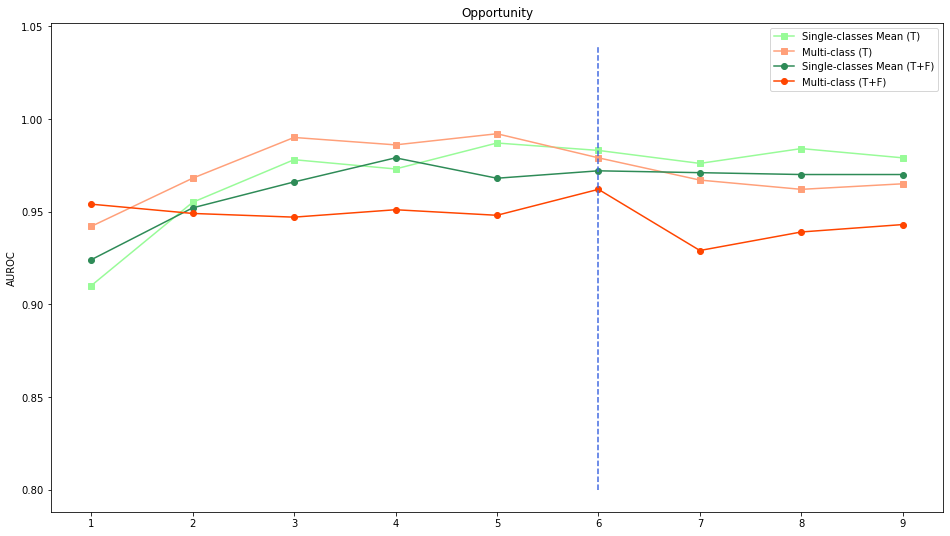

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.910, 0.955, 0.978, 0.973, 0.987, 0.983, 0.976, 0.984, 0.979],
          [0.942, 0.968, 0.990, 0.986, 0.992, 0.979, 0.967, 0.962, 0.965],
          [0.924, 0.952, 0.966, 0.979, 0.968, 0.972, 0.971, 0.970, 0.970],
          [0.954, 0.949, 0.947, 0.951, 0.948, 0.962, 0.929, 0.939, 0.943]])


x = [ round(num, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (T)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (T)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (T+F)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (T+F)')
plt.plot([6 for num in range(1,10)],[round(num*0.01, 2) for num in range(80, 106, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("Opportunity")
plt.ylabel("AUROC")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

ratio  = \
np.array([[0.881, 0.887, 0.880, 0.880, 0.886, 0.879, 0.886, 0.884, 0.879],
          [0.886, 0.893, 0.902, 0.899, 0.881, 0.895, 0.886, 0.867, 0.895],
          [0.988, 0.989, 0.990, 0.986, 0.986, 0.985, 0.989, 0.988, 0.986],
          [0.986, 0.979, 0.977, 0.977, 0.977, 0.978, 0.985, 0.974, 0.962]])


x = [ round(num*0.1, 1) for num in range(1,10) ]
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1, 1, 1)

plt.plot(x, ratio[0], color='palegreen', marker='s', linestyle='solid', \
         label='Single-classes Mean (Doo-RE)')
plt.plot(x, ratio[1], color='lightsalmon', marker='s', linestyle='solid', \
         label='Multi-class (DOO-RE)')

plt.plot(x, ratio[2], color='seagreen', marker='o', linestyle='solid', \
         label='Single-classes Mean (Opp)')
plt.plot(x, ratio[3], color='orangered', marker='o', linestyle='solid', \
         label='Multi-class (opp)')
#plt.plot([6 for num in range(1,10)],[round(num*0.01, 2) for num in range(80, 106, 3)] , color='royalblue', linestyle='--')
# plt.plot(x, ratio[5], color='seagreen', marker='o', linestyle='solid', \
#          label='Single-classes Mean')

# plt.plot(x, ratio[4], color='tomato', marker='o', linestyle='solid', \
#          label='Multi-class')


plt.title("parameter")
plt.ylabel("AUROC")

plt.legend()
plt.show()

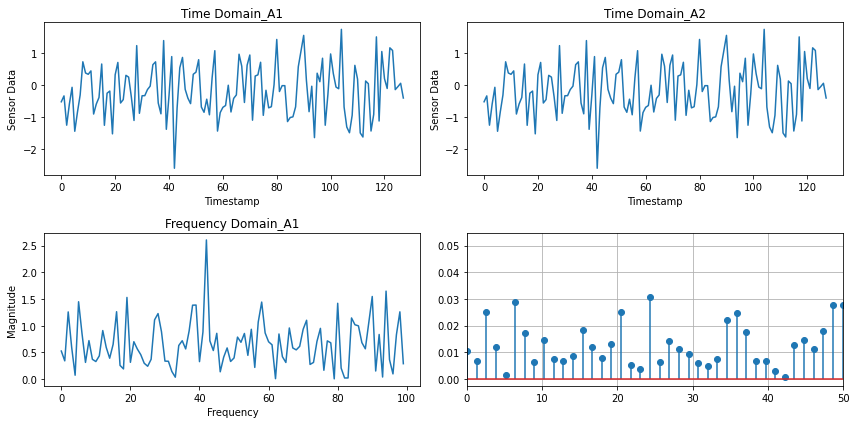

In [ ]:
# Visualization for CASAS
import torch
import numpy as np
import matplotlib.pyplot as plt
import math


# Generate random input data with shape (batch_size, channels, length)
batch_size = 64
channels = 1
length = 128  # Length of the input signal

# Create random input data
input_data = torch.randn(batch_size,  length, channels)

# Apply FFT along the last dimension (time dimension)
# We use torch.fft.fft to perform the FFT

# 입력 데이터 생성
input_data_1 = input_data[0]  # Activity 1
fft_result = np.fft.fft(input_data_1) # FFT
fft_result_2 = np.fft.rfft(input_data_1) 


# 입력 데이터 생성
input_data_1 =input_data_1 # Activity 1
input_data_2 = input_data_1   # Activity 2

# 시간 도메인 데이터 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(input_data_1)
plt.title("Time Domain_A1")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")

plt.subplot(2, 2, 2)
plt.plot(input_data_2)
plt.title("Time Domain_A2")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Data")


# 주파수 도메인 데이터 시각화
freq_data_1 = np.abs(np.fft.fft((input_data_1[:100 , : ])))
amb = freq_data_1 * (2/len(freq_data_1))
freqqq= np.fft.fftfreq(len(freq_data_1), 1/length)
freq_data_2 = np.fft.rfft((input_data_2))

plt.subplot(2, 2, 3)
plt.plot(freq_data_1)
plt.title("Frequency Domain_A1")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

plt.subplot(2, 2, 4)
plt.xlim(0,50)
plt.stem(freqqq, amb)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention_map(attention_map, layer_name, head):
    """
    Visualize the attention map for a given layer and head.

    Args:
        attention_map (Tensor): The attention map for a specific layer and head.
        layer_name (str): The name or index of the layer.
        head (int): The attention head index.
    """
    sns.set()
    plt.figure(figsize=(8, 6))
    plt.title(f'Self-Attention Map for Layer {layer_name}, Head {head}')
    sns.heatmap(attention_map[0].detach().numpy(), cmap='viridis', annot=True, fmt='.2f', cbar=False)
    plt.xlabel('Query positions')
    plt.ylabel('Key positions')
    plt.show()

# Example TransformerEncoderLayer
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)

# Generate some input data (adjust the shape according to your needs)
input_data = torch.rand((10, 1, 512))  # (sequence_length, batch_size, embedding_dim)

# Calculate the self-attention weights for a specific layer (e.g., the first layer)
output, self_attention_weights = encoder_layer.self_attn(input_data, input_data, input_data)
print(self_attention_weights.shape)

# Loop through heads and visualize each attention map
for head_idx in range(self_attention_weights.size(0)):
    attention_map = self_attention_weights[head_idx].unsqueeze(0)  # Extract the attention maps from the tuple
    visualize_attention_map(attention_map, layer_name="TransformerEncoderLayer", head=head_idx)


torch.Size([1, 10, 10])


IndexError: index 1 is out of bounds for dimension 0 with size 1